**Objective:** 

In this tutorial we will create a simple magnetic problem from scratch using the SimPEG framework.

We are using the integral form of the magnetostatic problem. In the absence of free-currents or changing magnetic field, magnetic material can give rise to a secondary magnetic field according to:

$$\vec b = \frac{\mu_0}{4\pi}  \int_{V}   \vec M \cdot \nabla \nabla \left(\frac{1}{r}\right) \; dV $$

Where $\mu_0$ is the magnetic permealitity of free-space, $\vec M$ is the magnetization per unit volume and $r$  defines the distance between the observed field $\vec b$ and the magnetized object. Assuming a purely induced response, the strenght of magnetization can be written as:

$$ \vec M = \mu_0 \kappa \vec H_0 $$

where $\vec H$ is an external inducing magnetic field, and $\kappa$ the magnetic susceptibility of matter.
As derived by Sharma 1966, the integral can be evaluated for rectangular prisms such that:

$$ \vec b(P) =  \mathbf{T} \cdot \vec H_0 \; \kappa $$

Where the tensor matrix $\bf{T}$ relates the three components of magnetization $\vec M$ to the components of the field $\vec b$:

$$\mathbf{T} =
	 \begin{pmatrix}
       		T_{xx} & T_{xy} & T_{xz}    \\
		T_{yx} & T_{yy} & T_{yz}    \\
		T_{zx} & T_{zy} & T_{zz}           
	\end{pmatrix} $$
    
In general, we discretize the earth into a collection of cells, each contributing to the magnetic data such that:

$$\vec b(P) = \sum_{j=1}^{nc} \mathbf{T}_j \cdot \vec H_0 \; \kappa_j$$

giving rise to a linear problem.


In [1]:
%matplotlib notebook

In [2]:
from SimPEG import Mesh, Directives, Maps, InvProblem, Optimization, DataMisfit, Inversion, Utils, Regularization
import SimPEG.PF as PF
import discretize
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [3]:
# First we need to define the direction of the inducing field
# As a simple case, we pick a vertical inducing field of magnitude 50,000nT. 
# From old convention, field orientation is given as an azimuth from North 
# (positive clockwise) and dip from the horizontal (positive downward).
H0 = (50000., 90.,0.)

# Assume all induced so the magnetization M is also in the same direction
M = np.array([90,0])

# Create a mesh
h = 5 # Core cell size
hxind = [(h,5,-1.3), (h, 20),(h,5,1.3)]
hyind = [(h,5,-1.3), (h, 20),(h,5,1.3)]
hzind = [(h,5,-1.3), (h, 10)]

mesh = Mesh.TensorMesh([hxind, hyind, hzind], 'CC0')
mesh.x0[2] -= mesh.vectorNz[-1]
# Assume flat topo for now, so all cells are active
nC   = mesh.nC 
actv = np.asarray(range(mesh.nC))


# Create and array of observation points
height = 5.
xr = np.linspace(-40., 40., 20)
yr = np.linspace(-40., 40., 20)
X, Y = np.meshgrid(xr, yr)
Z = np.ones(X.size)*(mesh.vectorNz[-1]+height) # Let just put the observation flat

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=H0)
survey = PF.BaseMag.LinearSurvey(srcField) 


Now that we have all our spatial components, we can create our linear system. For a single location and single component of the data, the system would looks like this:

$$ b_x =
	\begin{bmatrix}
	T_{xx}^1 &... &T_{xx}^{nc} & T_{xy}^1 & ... & T_{xy}^{nc} & T_{xz}^1 & ... & T_{xz}^{nc}\\
	 \end{bmatrix}
	 \begin{bmatrix}
		\mathbf{M}_x \\ \mathbf{M}_y \\ \mathbf{M}_z
	\end{bmatrix} \\ $$

where each of $T_{xx},\;T_{xy},\;T_{xz}$ are [nc x 1] long. For the $y$ and $z$ component, we need the two other rows of the tensor $\mathbf{T}$.
In our simple induced case, the magnetization direction $\mathbf{M_x,\;M_y\;,Mz}$ are known and assumed to be constant everywhere, so we can reduce the size of the system such that: 

$$ \vec{\mathbf{d}}_{\text{pred}} = (\mathbf{T\cdot M})\; \kappa$$



In most geophysical surveys, we are not collecting all three components, but rather the magnitude of the field, or $Total\;Magnetic\;Intensity$ (TMI) data.
Because the inducing field is really large, we will assume that the anomalous fields are parallel to $H_0$:

$$ d^{TMI}  = \hat H_0 \cdot \vec d$$

We then end up with a much smaller system:

$$ d^{TMI} = \mathbf{F\; \kappa}$$

where $\mathbf{F} \in \mathbb{R}^{nd \times nc}$ is our $forward$ operator.

In [4]:
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, -100)

# Creat reduced identity map
idenMap = Maps.IdentityMap(nP = int(mesh.nC))

# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap = idenMap, actInd = actv)

# Pair the survey and problem
survey.pair(prob)

# Pre-compute forward operator
# Create sensitivity weights from our linear forward operator
wr = prob.getJtJdiag(np.zeros(mesh.nC))**0.5
wr = (wr/np.max(wr))

Begin forward: M=H0, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


We can now create a susceptibility model and generate data

Lets start with a simple block in half-space

<IPython.core.display.Javascript object>


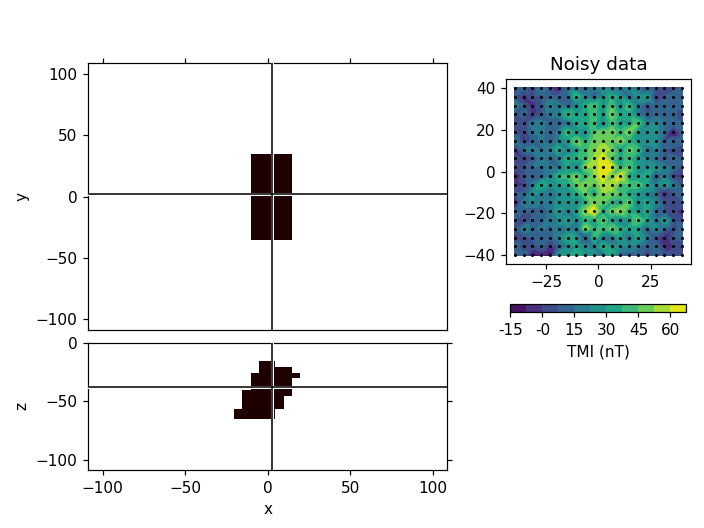

In [5]:

fig = plt.figure()
def modelGen(width, length, height, depth, azm, dip, sus, noise):
    
    # Take an inclination and declination angle and return a rotation matrix
    phi = -np.deg2rad(np.asarray(dip))
    theta = -np.deg2rad(np.asarray(azm))

    Ry = np.asarray([[np.cos(phi), 0, -np.sin(phi)],
                    [0, 1, 0],
                    [np.sin(phi), 0, np.cos(phi)]])

    Rz = np.asarray([[np.cos(theta), -np.sin(theta), 0],
                    [np.sin(theta), np.cos(theta), 0],
                    [0, 0, 1]])

    R = Rz.dot(Ry)
    
    # Define a block with 8 corners 
    x, y, z = np.meshgrid(np.r_[-width/2,width/2], np.r_[-length/2,length/2], np.r_[-height/2,height/2])

    # Rotate the block
    corners = np.dot(R, np.c_[np.ravel(x), np.ravel(y), np.ravel(z)].T).T

    # Move the top of the block down
    corners[:, 2] -= (depth + corners[:, 2].max())

    # Get indices inside
    ind = Utils.ModelBuilder.PolygonInd(mesh, corners)

    # Create a zero model and add the susceptible block
    model = np.zeros(mesh.nC)
    model[ind] = sus

    fig.clf()
    tracker = discretize.View.Slicer(mesh, model, pcolorOpts={'cmap':'pink_r'})
    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)

    # Compute linear forward operator and compute some data
    data = prob.fields(model)
    
    # Add random noise
    np.random.seed(8)
    floor = np.ones(survey.nD) * noise
    randN = np.random.randn(survey.nD) * floor
    survey.dobs = data + randN
    survey.wd = floor

    
    ax = plt.subplot(3,3,3)
    plt.axis('off')
    ax1 = plt.axes([0.6,.35,.5,0.5])
    im = Utils.plot2Ddata(xyzLoc, survey.dobs, ax=ax1)
    ax1.scatter(xyzLoc[:,0], xyzLoc[:,1], 1, c='k')
    ax1.set_title('Noisy data')
    cbar = plt.colorbar(im[0], orientation='horizontal', shrink=0.5, format='%.0f')
    cbar.set_label("TMI (nT)")

    return survey


keys = {
        "width":widgets.FloatSlider(min=5, max=100, step=5, value=20,continuous_update=False, description='Width'),
        "length":widgets.FloatSlider(min=5, max=100, step=5, value=50,continuous_update=False, description="Length"),
        "height":widgets.FloatSlider(min=5, max=100, step=5, value=50,continuous_update=False, description="Height"),
        "depth":widgets.FloatSlider(min=0, max=100, step=5, value=5,continuous_update=False, description="Depth Top"),
        "azm":widgets.FloatSlider(min=-90, max=90, step=5, value=0,continuous_update=False, description="Azimuth"),
        "dip":widgets.FloatSlider(min=-90, max=90, step=5, value=45,continuous_update=False, description="Dip"),
        "sus":widgets.FloatSlider(min=0, max=0.1, step=0.01, value=0.01,continuous_update=False, description="Sus (SI)"),
        "noise":widgets.FloatSlider(min=0, max=20, step=1., value=1.,continuous_update=False, description="Noise (nT)"),
}
widgListL = [keys[key] for key in list(keys.keys())[:4]]
widgListR = [keys[key] for key in list(keys.keys())[4:]]
out = widgets.interactive_output(modelGen, keys)    
left = widgets.VBox(widgListL,
            layout=widgets.Layout(
                width='35%', height='600px', margin='60px 0px 0px 0px'
            )
        )      
right = widgets.VBox(widgListR,
            layout=widgets.Layout(
                width='35%', height='600px', margin='60px 0px 0px 0px'
            )
        ) 

box = widgets.HBox([out, left, right])
display(box)
plt.show()


# Invert without sensitivity weighting

In [6]:
# Starting model
m0 = np.ones(mesh.nC)  * 1e-4

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.mref = np.zeros(mesh.nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=20, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3, maxIRLSiter=0)
update_Jacobi = Directives.UpdatePreconditioner()

# saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])


prob.model = m0
mrec = inv.run(m0)

fig, ax2 = plt.figure(), plt.subplot(1,2,1)
im = Utils.plot2Ddata(xyzLoc, invProb.dpred, ax=ax2)
ax2.set_title('Predicted data')
cbar = plt.colorbar(im[0], orientation='horizontal', shrink=0.5, format='%.0f')
cbar.set_label("TMI (nT)")

ax3 = plt.subplot(1,2,2)
im = Utils.plot2Ddata(xyzLoc, (survey.dobs-invProb.dpred)/survey.wd, ax=ax3)
ax3.set_title('Normalize Residual')
cbar = plt.colorbar(im[0], orientation='horizontal', shrink=0.5, format='%.0f')



SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.54e+03  1.31e+05  2.57e-02  1.31e+05    8.80e+02      0              
   1  3.27e+03  5.64e+02  3.34e-01  1.66e+03    9.56e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 0.007640522941338799 eps_q: 0.007640522941338799
Reach maximum number of IRLS cycles: 0
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <

<IPython.core.display.Javascript object>

# Recovered model
Most of the susceptibility is at the surface.

In [7]:
mesh.plot_3d_slicer(mrec, transparent='slider', pcolorOpts={'cmap':'pink_r'})


<IPython.core.display.Javascript object>

# Add sensitivity weights and re-invert

In [8]:
# Starting model
m0 = np.ones(mesh.nC)  * 1e-4

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.norms = np.c_[0, 1, 1, 1]
reg.cell_weights = wr  # Apply sensitivity weights here !!
reg.mref = np.zeros(mesh.nC)

# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1./survey.wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=30, lower=0., upper=10.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-4)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio = 1e0)

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-4, maxIRLSiter=15, betaSearch=False)
update_Jacobi = Directives.UpdatePreconditioner()

# saveModel = Directives.SaveUBCModelEveryIteration(mapping=actvMap)
# saveModel.fileName = work_dir + out_dir + 'ModelSus'

inv = Inversion.BaseInversion(invProb,
                              directiveList=[betaest, IRLS, update_Jacobi])


prob.model = m0
mrec = inv.run(m0)

fig, ax2 = plt.figure(), plt.subplot(1,2,1)
im = Utils.plot2Ddata(xyzLoc, invProb.dpred, ax=ax2)
ax2.set_title('Predicted data')
cbar = plt.colorbar(im[0], orientation='horizontal', shrink=0.5, format='%.0f')
cbar.set_label("TMI (nT)")

ax3 = plt.subplot(1,2,2)
im = Utils.plot2Ddata(xyzLoc, (survey.dobs-invProb.dpred)/survey.wd, ax=ax3)
ax3.set_title('Normalize Residual')
cbar = plt.colorbar(im[0], orientation='horizontal', shrink=0.5, format='%.0f')

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.81e+07  1.31e+05  3.56e-06  1.31e+05    8.83e+02      0              
   1  2.41e+07  1.10e+04  2.57e-04  1.71e+04    7.82e+02      0              
   2  1.20e+07  2.45e+03  4.28e-04  7.59e+03    6.30e+02      0   Skip BFGS  
   3  6.01e+06  9.48e+02  5.05e-04  3.98e+03    6.64e+02      0   Skip BFGS  
   4  3.01e+06  4.11e+02  5.57e-04  2.09e+03    7.33e+02      0   Skip BFGS  
   5  1.50e+06  2.47e

KeyboardInterrupt: 

# $\ell_2$ model

In [ ]:
mesh.plot_3d_slicer(invProb.l2model, transparent='slider', pcolorOpts={'cmap':'pink_r'})


# $\ell_p$ model

In [ ]:
mesh.plot_3d_slicer(mrec, transparent='slider', pcolorOpts={'cmap':'pink_r'})
